In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

In [2]:
# Load dataset
df = pd.read_csv('dataset_clean.csv')
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df['Hari'] = df['Tanggal'].dt.day
df['Bulan'] = df['Tanggal'].dt.month
df['Tahun'] = df['Tanggal'].dt.year

input_features = ['Hari', 'Bulan', 'Tahun']
output_features = ['BawangMerah']

x = df[input_features].values
y = df[output_features].values

print(x)

[[   1    1 2022]
 [   2    1 2022]
 [   3    1 2022]
 ...
 [  28    9 2024]
 [  29    9 2024]
 [  30    9 2024]]


In [3]:
# Scaling
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

In [4]:
# Train test split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, shuffle=False)

In [5]:
#timesteps = 30 #data 30 hari untuk input
#n_features_input = len(input_features)
#n_features_output = len(output_features)

In [6]:
# Sequence generator
timesteps = 30
def create_sequences(x, y, time_steps):
    x_seq, y_seq = [], []
    for i in range(len(x) - time_steps):
        x_seq.append(x[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    return np.array(x_seq), np.array(y_seq)

x_train_seq, y_train_seq = create_sequences(x_train, y_train, timesteps)
x_test_seq, y_test_seq = create_sequences(x_test, y_test, timesteps)

In [7]:
# Build model
model = Sequential()
model.add(LSTM(60, input_shape=(timesteps, len(input_features)), return_sequences=True))
model.add(LSTM(60))
model.add(Dense(len(output_features)))
model.compile(loss='mean_absolute_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Train
model.fit(x_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1884
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1183
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1072
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1089
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1014
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1061
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0986
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1037
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1000
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0905
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0950
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0894
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0806
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0838
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0682
Epoch 16/50
25/25 ━

In [9]:
# Predict test set
y_test_pred_scaled = model.predict(x_test_seq)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
y_test_asli = scaler_y.inverse_transform(y_test_seq)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [10]:
# --- EVALUASI: MAE, RMSE, MAPE ---
mae = mean_absolute_error(y_test_asli, y_test_pred)
mse = mean_squared_error(y_test_asli, y_test_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_asli - y_test_pred) / y_test_asli)) * 100  # pastikan y_test_asli ≠ 0

print("\n=== Evaluasi Model pada Test Set ===")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


=== Evaluasi Model pada Test Set ===
MAE  : 10442.31
RMSE : 12001.89
MAPE : 25.05%


In [11]:
# --- FORECASTING KE DEPAN ---
user_input_date = '2025-12-31'  # <-- ini bisa diganti dengan input dari user di web
target_date = pd.to_datetime(user_input_date)

last_30_days = df[input_features].values[-timesteps:]
last_30_scaled = scaler_x.transform(last_30_days)

predicted_dates = []
predicted_prices = []

current_input = last_30_scaled.copy()
current_date = df['Tanggal'].iloc[-1]

while current_date < target_date:
    pred_scaled = model.predict(np.array([current_input]))
    pred_real = scaler_y.inverse_transform(pred_scaled)[0]
    predicted_prices.append(pred_real[0])
    current_date += timedelta(days=1)
    predicted_dates.append(current_date)

    next_date_features = [current_date.day, current_date.month, current_date.year]
    next_scaled = scaler_x.transform([next_date_features])
    current_input = np.vstack((current_input[1:], next_scaled))

print("\n=== Prediksi Ke Depan ===")
for date, price in zip(predicted_dates, predicted_prices):
    print(f"Tanggal: {date.strftime('%Y-%m-%d')}, Harga: {price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

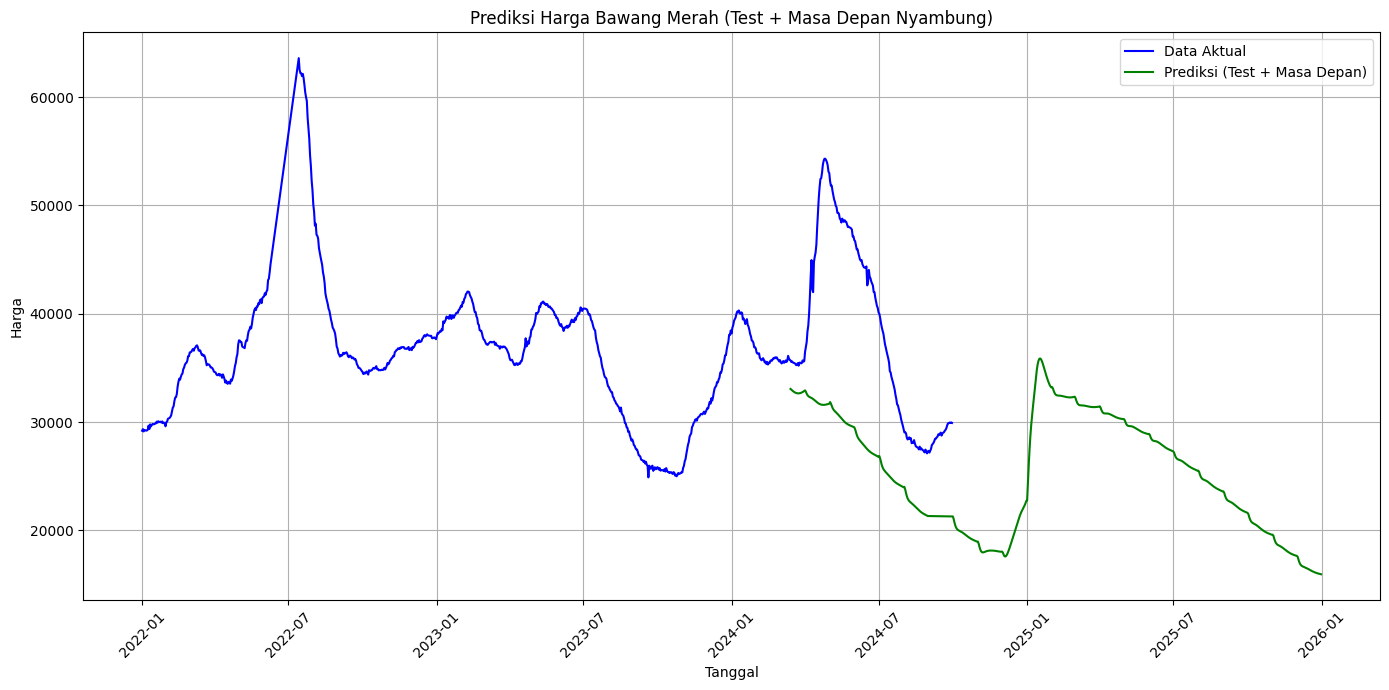

In [12]:
# Data test prediction
start_index_test = len(x_train_seq) + timesteps
dates_test = df['Tanggal'].iloc[start_index_test:start_index_test + len(y_test_seq)]
df_test_pred = pd.DataFrame({
    'Tanggal': dates_test,
    'Harga': y_test_pred[:, 0]
})

# Data prediksi masa depan
df_future_pred = pd.DataFrame({
    'Tanggal': predicted_dates,
    'Harga': predicted_prices
})

# Gabung data test pred dan masa depan agar nyambung
df_pred_combined = pd.concat([df_test_pred, df_future_pred], ignore_index=True)

# Gabung dengan data aktual
df_actual = df[['Tanggal', 'BawangMerah']].copy()
df_actual.columns = ['Tanggal', 'Harga']

# Plot final
plt.figure(figsize=(14, 7))

plt.plot(df_actual['Tanggal'], df_actual['Harga'], label="Data Aktual", color='blue')
plt.plot(df_pred_combined['Tanggal'], df_pred_combined['Harga'], label="Prediksi (Test + Masa Depan)", color='green')

plt.title("Prediksi Harga Bawang Merah (Test + Masa Depan Nyambung)")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


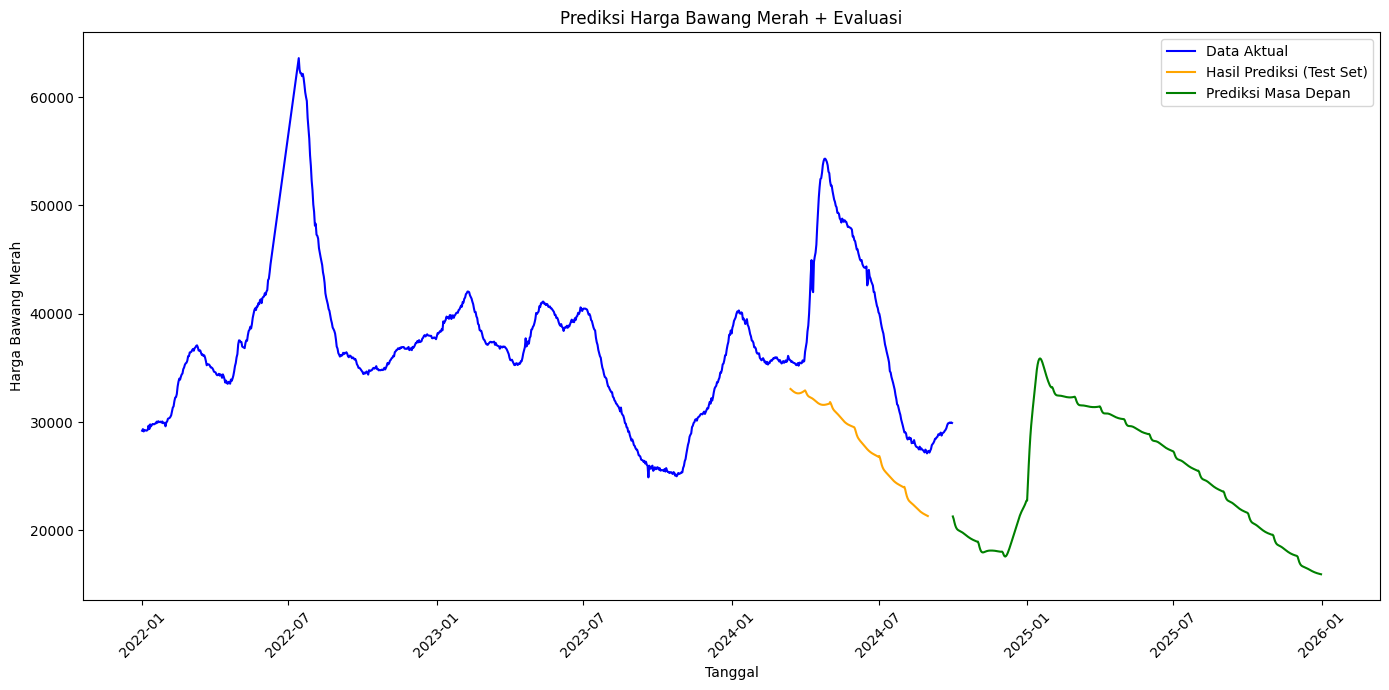

In [13]:
# --- PLOT GABUNGAN ---
plt.figure(figsize=(14, 7))

# Data aktual
plt.plot(df['Tanggal'], df['BawangMerah'], label="Data Aktual", color='blue')

# Hasil test set
start_index_test = len(x_train_seq) + timesteps
dates_test = df['Tanggal'].iloc[start_index_test:start_index_test + len(y_test_seq)]
plt.plot(dates_test, y_test_pred[:, 0], label="Hasil Prediksi (Test Set)", color='orange')

# Prediksi masa depan
plt.plot(predicted_dates, predicted_prices, label="Prediksi Masa Depan", color='green')

plt.xlabel("Tanggal")
plt.ylabel("Harga Bawang Merah")
plt.title("Prediksi Harga Bawang Merah + Evaluasi")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# from tensorflow.keras.models import save_model

# # Simpan model dalam format .h5
# save_model(model, 'model_lstm.h5')
import joblib
import pickle

pickle.dump(model, open('model.pkl', 'wb'))
# joblib.dump(scaler_x, 'scaler_x.save')
# joblib.dump(scaler_y, 'scaler_y.save')

In [15]:
# import joblib
# from sklearn.preprocessing import MinMaxScaler

# # Simpan scaler
# joblib.dump(scaler, 'scaler.pkl')

# # Alternatif dengan pickle
# import pickle
# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

In [16]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# import tensorflow as tf
# from datetime import datetime, timedelta

# # Load the dataset
# df = pd.read_csv('dataset_clean.csv', parse_dates=['Tanggal'])
# df.set_index('Tanggal', inplace=True)

# # Handle missing values by forward filling
# df.fillna(method='ffill', inplace=True)

# # Select a commodity to predict (you can change this)
# COMMODITY = 'BerasMedium'

# # Prepare data for the selected commodity
# data = df[[COMMODITY]].values

# # Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data)

# # Function to create sequences for LSTM
# def create_dataset(data, look_back=60):
#     X, y = [], []
#     for i in range(len(data)-look_back-1):
#         X.append(data[i:(i+look_back), 0])
#         y.append(data[i + look_back, 0])
#     return np.array(X), np.array(y)

# # Create training data
# look_back = 60  # Number of previous days to use for prediction
# X, y = create_dataset(scaled_data, look_back)

# # Split into train and test sets (80-20 split)
# train_size = int(len(X) * 0.8)
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# # Reshape input to be [samples, time steps, features]
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# # Build LSTM model
# model = Sequential()
# model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
# model.add(Dropout(0.2))
# model.add(LSTM(50, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(50))
# model.add(Dropout(0.2))
# model.add(Dense(1))

# model.compile(optimizer='adam', loss='mean_squared_error')

# # Early stopping to prevent overfitting
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model
# history = model.fit(
#     X_train, y_train,
#     epochs=100,
#     batch_size=32,
#     validation_data=(X_test, y_test),
#     callbacks=[early_stop],
#     verbose=1
# )

# # Make predictions
# train_predict = model.predict(X_train)
# test_predict = model.predict(X_test)

# # Inverse transform predictions to original scale
# train_predict = scaler.inverse_transform(train_predict)
# y_train = scaler.inverse_transform([y_train])
# test_predict = scaler.inverse_transform(test_predict)
# y_test = scaler.inverse_transform([y_test])

# # Calculate RMSE
# train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
# test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
# print(f'Train RMSE: {train_rmse:.2f}')
# print(f'Test RMSE: {test_rmse:.2f}')

# # Function to predict future prices
# def predict_future(model, last_sequence, n_days):
#     predictions = []
#     current_sequence = last_sequence.copy()

#     for _ in range(n_days):
#         # Reshape and predict
#         current_sequence_reshaped = current_sequence.reshape((1, look_back, 1))
#         next_pred = model.predict(current_sequence_reshaped, verbose=0)

#         # Store prediction
#         predictions.append(next_pred[0,0])

#         # Update sequence
#         current_sequence = np.roll(current_sequence, -1)
#         current_sequence[-1] = next_pred

#     # Inverse transform to original scale
#     predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

#     return predictions

# # Get the last sequence from the data
# last_sequence = scaled_data[-look_back:]

# # Predict next 30 days
# n_days = 30
# future_predictions = predict_future(model, last_sequence, n_days)

# # Create future dates
# last_date = df.index[-1]
# future_dates = [last_date + timedelta(days=i) for i in range(1, n_days+1)]

# # Plot the results
# plt.figure(figsize=(15, 7))
# plt.plot(df.index, df[COMMODITY], label='Historical Data')
# plt.plot(future_dates, future_predictions, 'r-', label='Future Predictions')
# plt.title(f'{COMMODITY} Price Prediction')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.grid()
# plt.show()

# # Save the model for later use in the web app
# model.save(f'{COMMODITY}_price_predictor.h5')

# # Save the scaler
# import joblib
# joblib.dump(scaler, f'{COMMODITY}_scaler.save')